In [1]:
import math
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import lag_plot
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

Using TensorFlow backend.


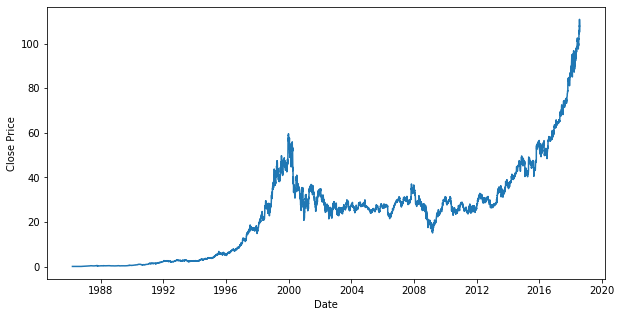

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('./Data/MSFT.csv', sep = ',',
                   parse_dates = ['Date'], index_col = 'Date',
                   date_parser = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d'))
plt.figure(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(data['Close']);

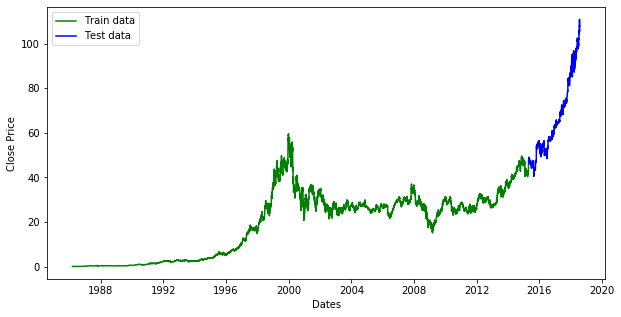

In [3]:
testTrainSplitPoint = int(len(data)*0.9)
train_data, test_data = data[0:testTrainSplitPoint], data[testTrainSplitPoint:]
plt.figure(figsize=(10,5))
plt.xlabel('Dates')
plt.ylabel('Close Price')
plt.plot(train_data['Close'], 'green', label='Train data')
plt.plot(test_data['Close'], 'blue', label='Test data')
plt.legend()

In [4]:
train = train_data['Close']
test = test_data['Close']
train = np.array([x for x in train]).reshape(-1, 1)
test = np.array([x for x in test]).reshape(-1, 1)

scaler = MinMaxScaler().fit(train)
train_scaled = scaler.transform(train)
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [5]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.20))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 50, batch_size = 7)

Epoch 1/50
7339/7339 [==============================] - 7s 983us/step - loss: 0.0042
Epoch 2/50
7339/7339 [==============================] - 6s 847us/step - loss: 0.0018
Epoch 3/50
7339/7339 [==============================] - 6s 871us/step - loss: 0.0014
Epoch 4/50
7339/7339 [==============================] - 6s 852us/step - loss: 0.0013
Epoch 5/50
7339/7339 [==============================] - 6s 861us/step - loss: 0.0013
Epoch 6/50
7339/7339 [==============================] - 6s 848us/step - loss: 0.0012
Epoch 7/50
7339/7339 [==============================] - 6s 857us/step - loss: 0.0011
Epoch 8/50
7339/7339 [==============================] - 6s 863us/step - loss: 0.0011
Epoch 9/50
7339/7339 [==============================] - 6s 834us/step - loss: 0.0011
Epoch 10/50
7339/7339 [==============================] - 6s 862us/step - loss: 0.0010
Epoch 11/50
7339/7339 [==============================] - 6s 875us/step - loss: 0.0010
Epoch 12/50
7339/7339 [==============================] - 7s 900

In [6]:
test_scaled = scaler.transform(test)
X_test = []
y_test = []
for i in range(timesteps, test.shape[0]):
    X_test.append(test_scaled[i-timesteps:i, 0])
    y_test.append(test_scaled[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

predicted_stock_price = scaler.inverse_transform(model.predict(X_test))

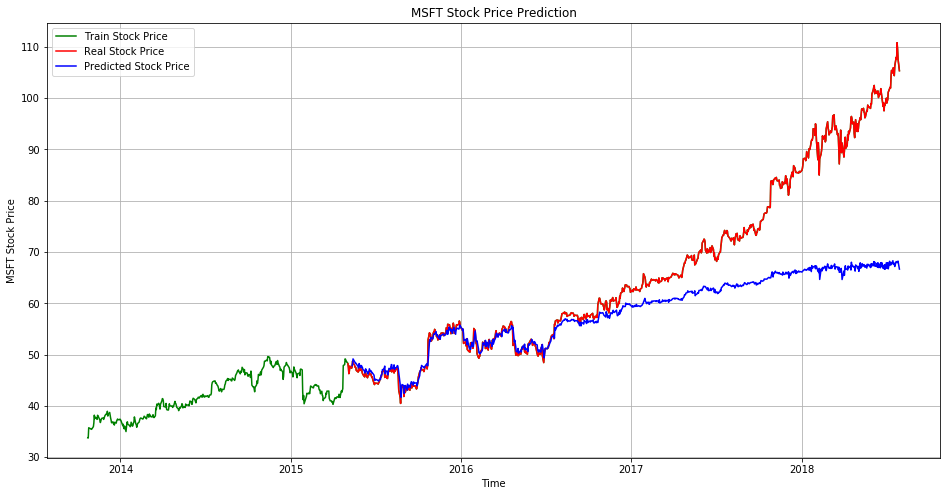

MSE: 3300.536348623694
MAE: 57.04631840507469
RMSE: 57.45029459126989


In [8]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-1200:], data['Close'].tail(1200), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, test, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index[7:], predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MSFT Stock Price')
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(y_test, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_test, predicted_stock_price)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y_test, predicted_stock_price))
print('RMSE: '+str(rmse))